# SHIPBOB CASE STUDY
## Denny Kang

Task : Extract tweets from twitter.com regarding any popular topic using hashtag. No limitation
on the size of the data but make sure have enough data to build some machine learning model
using the data

For this case study, I decided to use the hashtag #muellerreport, a reference to the Special Counsel's investigation. I chose this hashtag because of the highly partisan opinions on the general subject, as well as the popularity of the topic.



In [ ]:
import tweepy
import json
import pandas as pd
import sys
import jsonpickle
import os
import config.py

searchQuery = '#muellerreport'  # this is what we're searching for
maxTweets = 500000 # Some arbitrary large number
tweetsPerQry = 100  # this is the max the API permits
fName = 'tweets.txt' # We'll store the tweets in a text file.

#set up REST API
auth = tweepy.AppAuthHandler(config.consumer_key, config.consumer_secret)
api = tweepy.API(auth,wait_on_rate_limit = True,wait_on_rate_limit_notify=False)

#restricted in rate limit, trying to get as many tweets as possible in the time given
tw_list = []

# If results only below a specific ID are, set max_id to that ID.
# else default to no upper limit, start from the most recent tweet matching the search query.
max_id = -1

tweetCount = 0
print("Downloading max {0} tweets".format(maxTweets))
with open(fName, 'w') as f:
    while tweetCount < maxTweets:
        try:
            if (max_id <= 0):
            #max_id <= 0 only at initialized pull
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry)
            else:
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                            max_id=str(max_id - 1))
            if not new_tweets:
                #reached limit on number of tweets, standard API access only goes back 7 days
                print("No more tweets found")
                break
            for tweet in new_tweets:
                tmp_dict = {
                    'created_at': tweet.created_at,
                    'coordinates' : tweet.coordinates,
                    'place' : tweet.place,
                    'text' : tweet.text,
                    'user' : tweet.user,
                    'entities' : tweet.entities,
                    'favorite_count' : tweet.favorite_count,
                    'retweet_count' : tweet.retweet_count}
                tw_list.append(tmp_dict)
                f.write(jsonpickle.encode(tweet._json, unpicklable=False) +
                        '\n')
                
            tweetCount += len(new_tweets)
            max_id = new_tweets[-1].id
        except tweepy.TweepError as e:
            break

print ("Downloaded {0} tweets, Saved to {1}".format(tweetCount, fName))


In [10]:
tweet_df = pd.DataFrame(tw_list)
#verify tweet data grabbed correctly
tweet_df.head()
#location data seems fairly sparse, will probably have to avoid using it

,coordinates,created_at,entities,favorite_count,place,retweet_count,text,user
0,None,2019-04-24 03:13:25,"{'hashtags': [], 'symbols': [], 'user_mentions...",0,None,5038,RT @SpeakerPelosi: Our Founders spoke about ho...,User(_api=<tweepy.api.API object at 0x000001CE...
1,None,2019-04-24 03:13:24,"{'hashtags': [{'text': 'MuellerReport', 'indic...",0,None,31,"RT @grantstern: Jee, I wonder why Saudi Arabia...",User(_api=<tweepy.api.API object at 0x000001CE...
2,None,2019-04-24 03:13:22,"{'hashtags': [], 'symbols': [], 'user_mentions...",0,None,2810,RT @RepDougCollins: Attorney General Barr has ...,User(_api=<tweepy.api.API object at 0x000001CE...
3,None,2019-04-24 03:13:22,"{'hashtags': [{'text': 'MuellerReport', 'indic...",0,None,2516,RT @tedlieu: Dear @TheJusticeDept Bill Barr: M...,User(_api=<tweepy.api.API object at 0x000001CE...
4,None,2019-04-24 03:13:21,"{'hashtags': [{'text': 'MuellerReport', 'indic...",0,None,35,RT @grantstern: Anyone who slams the #MuellerR...,User(_api=<tweepy.api.API object at 0x000001CE...


In [23]:
#saving tweets to avoid rerunning initial tweet pull
tweet_df.to_csv('report_tweets.csv', index=False)

#if rerunning without pulling from twitter, uncomment following line
#tweet_df = pd.read_csv('report_tweets.csv')

In [33]:
#extract some of the fields in entities and user
tweet_df['hashtags'] = tweet_df['entities'].apply(lambda entity: entity['hashtags'])
tweet_df['symbols'] = tweet_df['entities'].apply(lambda entity: entity['symbols'])
tweet_df['user_mentions'] = tweet_df['entities'].apply(lambda entity: entity['user_mentions'])
tweet_df['user_description'] = tweet_df['user'].apply(lambda user: user.description)
tweet_df['user_name'] = tweet_df['user'].apply(lambda user: user.screen_name)
tweet_df['user_followers_count'] = tweet_df['user'].apply(lambda user: user.followers_count)
tweet_df['user_statuses_count'] = tweet_df['user'].apply(lambda user: user.statuses_count)
tweet_df['user_favourites_count'] = tweet_df['user'].apply(lambda user: user.favourites_count)

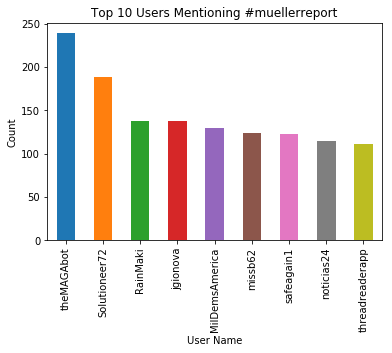

In [34]:
#plot most frequent users of the hashtag
user_num_tweets = tweet_df.groupby('user_name')['created_at'].count().sort_values(ascending=False)
ax = user_num_tweets[1:10].plot(kind='bar',title='Top 10 Users Mentioning #muellerreport')
ax.set_xlabel('User Name')
ax.set_ylabel('Count')
plt.show()

Upon investigation,two of the most prevalent users tweeting about the Mueller report have obvious partisan biases, theMAGAbot (R) and Solutioneer72 (D). We can observe whether they have a bias in their tweets by observing the distributions of mentions that each user has in their tweets.

[52313, 36832, 14568, 12248, 10562, 10159, 9666, 9501, 9366, 7352]


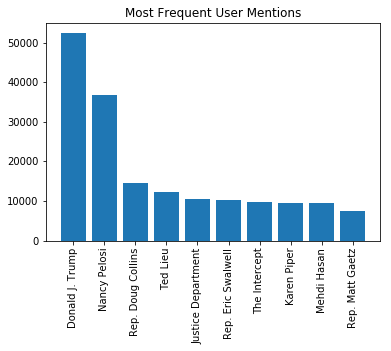

In [141]:
#plot most frequent user mentions among grabbed tweets
from collections import Counter

#as each tweet can have multiple mentions, we can use a Counter to 
#analyze the frequency of each mention by tweet
def user_mention_counts(df,topn=10):
    user_mention_counter = Counter()
    for user_mentions in df['user_mentions']:
        names = [mention['name'] for mention in user_mentions]
        user_mention_counter.update(names)
    most_common = user_mention_counter.most_common(topn)
    return most_common

common_mentions = user_mention_counts(tweet_df)
vals = [y for x,y in common_mentions]
labels = [x for x,y in common_mentions]
ax = plt.bar(np.arange(10),vals,align='center',tick_label = labels)
plt.title('Most Frequent User Mentions')
plt.xticks(rotation=90)
plt.show()

Mentions in tweets regarding the Mueller report follow logically from intuition. At number 1, we have Donald Trump, the subject of the investigation

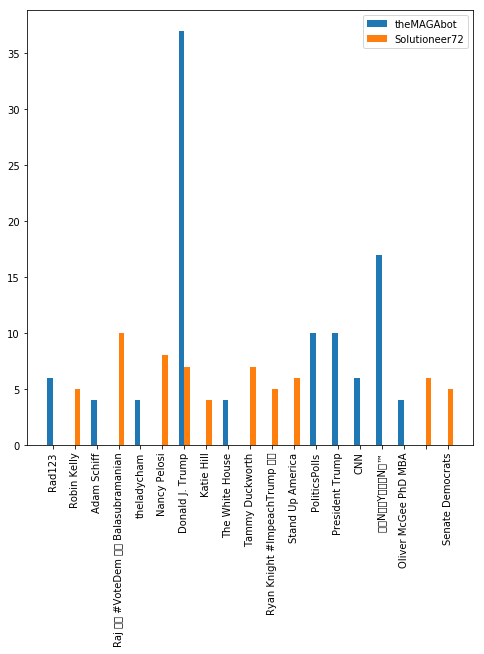

In [134]:
#grab tweets posted by Republican and Democratic posters
user_mention_by_partisanship = tweet_df[(tweet_df['user_name'] == 'theMAGAbot')|\
                                        (tweet_df['user_name']=='Solutioneer72')]
grouped = user_mention_by_partisanship.groupby('user_name')
referrent = set()
mentions = []
for user,group in grouped:
    common_mentions = user_mention_counts(group,topn=10)
    #grab all mentions in top 10 mentions
    labels = [ref for ref,count in common_mentions]
    #keep unique mentions posted by either user
    referrent.update(set(labels))
    mentions.append((user,dict(common_mentions)))

mention_dict = {'theMAGAbot':[],'Solutioneer72':[]}

for ref in referrent:
    for user,user_mentions in mentions:
        tmp_list = mention_dict[user]
        try:
            tmp_list.append(user_mentions[ref])
        except KeyError:
        #if referrent not in counter, then user did not mention at all
            tmp_list.append(0)
        mention_dict.update({user:tmp_list})

bar_width = .25
range1 = np.arange(len(referrent))
range2 = [x + bar_width for x in range1]
plt.figure(figsize=(8,8))
plt.bar(range1,mention_dict['theMAGAbot'],width = bar_width,\
        align='center',label = 'theMAGAbot')
plt.bar(range2,mention_dict['Solutioneer72'],width = bar_width,\
        align='center',label = 'Solutioneer72')
plt.xticks([r + bar_width/2 for r in range1], list(referrent) )
plt.xticks(rotation=90)
plt.legend()

plt.show()

From looking at the mentions from these two users, we can see that there exists a slight partisan bias. Both users mention Donald Trump, but theMAGAbot mentions him far more often than Solutioneer72. We can also see that Solutioneer72 tweets at a wide variety of Democratic politicians, such as Nancy Pelosi and Katie Hill, whereas theMAGAbot does not reference them at all. Classifying partisanship based on who the users mentioned may be predictive, though this is an example based only on two users.

I now turn attention to the actual text data in the tweet. Instead of looking at counts, we examine the semantics and structure of the tweets themselves to analyze partisanship.

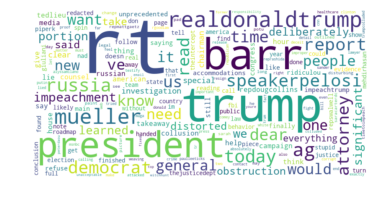

In [147]:
import re
import string
from wordcloud import WordCloud
from nltk.corpus import stopwords
from matplotlib import pyplot as plt

#standard preprocessing on text, removing all punctuation, converting to lower case,
#returning a cleaned string
def clean_text(text):
    text = text.lower()
    #remove &amp
    text = re.sub(r'&amp',' ',text)
    #remove … symbol
    text = re.sub(r'…', '',text)
    #remove all punctuation
    remv_punct = text.translate(str.maketrans('', '', string.punctuation))
    #split on whitespace
    tokens = re.split(r'[\s]+',remv_punct)
    #remove all urls and remove all stop words
    stopWords = set(stopwords.words('english'))
    rmv_url = [token for token in tokens if 'http' not in token and token not in stopWords]
    return rmv_url

#decompose tweets into tokens
tweet_df['tokens'] = [clean_text(tweet) for tweet in tweet_df['text']]
#create a cleaned version of the text by joining tokens with spaces
tweet_df['cleaned_text'] = tweet_df.apply(lambda row: ' '.join(row['tokens']),axis = 1)
long_text = ' '.join(tweet for tweet in tweet_df['cleaned_text'])
#removing muellerreport and mullerreport form the wordcloud, as it will appear in every tweet
wordcloud = WordCloud(stopwords = ['muellerreport','mullerreport'],
                      background_color = 'white',height=400,width=800,
                      collocations=False).generate(long_text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


One of the most common words in the raw data grab is RT, so there may very well be a ton of duplicate tweets in the corpus. To avoid this issue, we can filter out all the tweets that start with RT @ to get all the unique tweets on this topic. We can still keep the raw data, using retweet information can be used to create things like follower graphs to see how often people retweet each other.

(75051, 18)


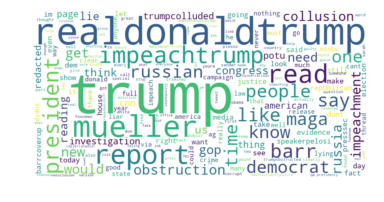

In [148]:
#use a boolean mask to filter out tweets that start with RT @
rt_mask = list(tweet_df.apply(lambda row: not 'RT @' in row['text'],axis=1))
tweet_df_no_rt = tweet_df[rt_mask]
#print resulting size of subset data
print(tweet_df_no_rt.shape)

#regenerate word cloud on subset of data
long_text = ' '.join(tweet for tweet in tweet_df_no_rt['cleaned_text'])
wordcloud = WordCloud(stopwords = ['muellerreport','mullerreport'],
                      background_color = 'white',height=400,width=800,
                      collocations=False).generate(long_text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

Removing all retweets gave different results, for example terms like 'MAGA' and 'redacted' are more visible. We can see that the most frequent term is Trump's twitter handle. It should be noted that most of the tweets grabbed in the initial pull were retweets (only 75,000 out of 500,000 were non retweets). Further analysis will be conducted on non retweets for reasons stated above.

In [149]:
#showing text output of most common terms found in tweets
cntr = Counter()
for tweet in tweet_df_no_rt['tokens']:
    cntr.update(tweet)
print(cntr.most_common(50))

[('muellerreport', 46717), ('trump', 11028), ('realdonaldtrump', 10400), ('mueller', 5895), ('report', 4958), ('read', 4414), ('impeachtrump', 3850), ('president', 2946), ('like', 2434), ('barr', 2363), ('people', 2275), ('maga', 2210), ('obstruction', 2054), ('one', 2040), ('know', 1950), ('would', 1935), ('impeachment', 1920), ('russia', 1896), ('democrats', 1867), ('time', 1857), ('get', 1803), ('gop', 1749), ('collusion', 1738), ('us', 1669), ('congress', 1641), ('reading', 1501), ('russian', 1467), ('redacted', 1460), ('trumpcolluded', 1453), ('cnn', 1415), ('potus', 1376), ('think', 1363), ('says', 1302), ('speakerpelosi', 1297), ('barrcoverup', 1291), ('even', 1290), ('im', 1273), ('said', 1272), ('news', 1263), ('see', 1262), ('investigation', 1252), ('justice', 1250), ('dont', 1242), ('still', 1219), ('need', 1210), ('say', 1197), ('right', 1186), ('2', 1171), ('house', 1167), ('evidence', 1135)]


In [ ]:
import gensim
#create Word2Vec embeddings of words to find similar terms
#using default parameters as a 
word2vec_model = gensim.models.Word2Vec(tweet_df_no_rt['tokens'],min_count =10)

Obstruction :


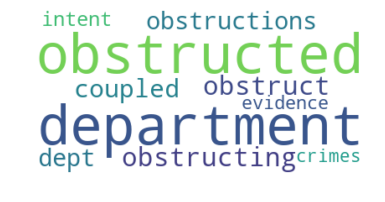

Barr :


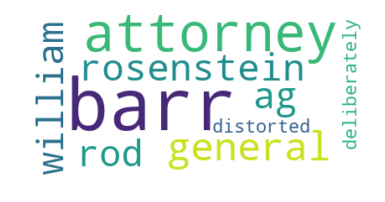

Russia :


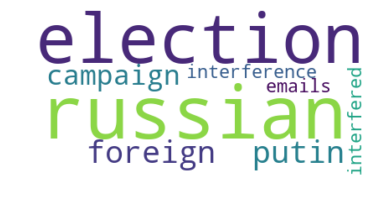

In [60]:
#create some word maps based on choice frequent terms and their most similar terms
def generate_most_similar_terms(word):
    kv = word2vec_model.wv.most_similar(word,topn=10)
    word_map_string = []
    for x,y in kv:
        #using cosine similarity generate by word2vec as measure of relevancy
        #more similar terms generate larger words in wordcloud
        similarity = round(100*y)
        word_map_string = word_map_string + ([x]*similarity)
    most_similar_terms = ' '.join(word_map_string)
    wordcloud = WordCloud(background_color = 'white',collocations=False).generate(most_similar_terms)
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()

#plot some examples of frequently appearing terms
print('Obstruction :')
generate_most_similar_terms('obstruction')
print('Barr :')
generate_most_similar_terms('barr')
print('Russia :')
generate_most_similar_terms('russia')

The Word2Vec model produces logical results, and returns words that arise in the context of a given term.

In [ ]:
#use average of word2vec embeddings to generate vector representations of each tweet
import numpy as np

def doc_vector(tokens,model):
    vecs = [model.wv[token] for token in tokens if token in model.wv]
    if vecs:
        #take tweet representation as simple average of word2vec vectors
        return np.average(vecs,axis=0)
    #if vecs is empty, no word in the tweet appears more than 10 times in the corpus
    #use an array of zeros as a special value
    return np.zeros(100)

#add column with vector representation of tweet
tweet_df_no_rt['doc_vec'] = tweet_df_no_rt['tokens'].apply(lambda row: doc_vector(row,word2vec_model))

In [144]:
#create k-means cluster to infer global structure of tweets
from sklearn.cluster import KMeans

#using 3 clusters as a start
num_clusters = 3
#stack document vectors to 
doc_vec_mat = np.stack(tweet_df_no_rt['doc_vec'],axis=0)
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(doc_vec_mat)
tweet_df_no_rt['kmeans_cluster'] = kmeans.labels_
for i in np.arange(num_clusters):
    cluster_ex = tweet_df_no_rt[tweet_df_no_rt['kmeans_cluster'] == i].iloc[0:5]
    print('Cluster Number: %d' % i)
    for x in cluster_ex['text']:
        print(x)
    print('-------------------')

C:\Users\Denny\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Cluster Number: 0
@realDonaldTrump You are not above our laws now &amp; you will never be... so get ready to join your #RussianKomrade… https://t.co/7vxrSd4VkQ
#DemocratsHateAmerica and #Trump so they are too busy with #Revenge on their minds. #Socialism is their #Endgame bu… https://t.co/vnb2gj5IZR
This EXACTLY. I agree with you PAM 💯% At this point not going for #impeachment gives POTUS a pass on all his impeac… https://t.co/7QJPRNuQqT
Interested to see what #mcgahn will do.  He doesn't work for the #whitehouse anymore, and it is #congress  that's s… https://t.co/JueTJVg16Z
Release the full #MuellerReport https://t.co/5RtU0tc2AO
-------------------
Cluster Number: 1
#QAnon #WWG1WGA #TrustThePlan #EnjoyTheShow #TheGreatAwakening #MuellerReport #WitchHunt #QArmy #PSBArmy https://t.co/wusEtNgONq
@RealDonalDrumpf @LindseyGrahamSC #LindseyGraham #MitchMcConnell 
#ObstructionOfJustice
#ImpeachDonaldTrump… https://t.co/lUrh5SsQAT
#MuellerReport #MAGA #KAG #BuildTheWall #BorderCrisis #Leftis

The cluster analysis resulted mixed results; it seems as if one of the clusters (Cluster 1) contains examples of anti-Trump rhetoric, though the other clusters don't seem to indicate a partisan bias either way or contain examples of both. Cluster 1 seems to contain tweets that have a lot of hashtags. These results could be that kmeans is not a great clustering algorithm for these tweets, or that the straight average of Word2Vec vectors is not a fidelitous representation of tweet sentiment.

In [145]:
#save final results to csv file
tweet_df_no_rt.to_csv('cleaned_tweets.csv',index=False)